In [1]:
import tensorflow as tf
import os

# 各フォルダパス
skins_dir = 'C:/Users/Owner/Desktop/archive/Skins'
missing_dir = 'C:/Users/Owner/Desktop/archive/Missing'
masks_dir = 'C:/Users/Owner/Desktop/archive/Masks'

def load_image(path, channels=4):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]に正規化
    return image

def load_sample(file_name):
    # file_name は Tensor で、ファイル名のみが入っている前提
    skin_path = tf.strings.join([skins_dir, file_name], separator='/')
    
    missing_file = tf.strings.join(["missing_", file_name])
    missing_path = tf.strings.join([missing_dir, missing_file], separator='/')
    
    mask_file = tf.strings.join(["mask_", file_name])
    mask_path = tf.strings.join([masks_dir, mask_file], separator='/')
    
    skin = load_image(skin_path, channels=4)
    missing = load_image(missing_path, channels=4)
    mask = load_image(mask_path, channels=1)  # マスクは1チャネル
    
    # 入力は欠損画像とマスクをチャネル方向に連結 (shape: (64, 64, 5))
    input_image = tf.concat([missing, mask], axis=-1)
    return input_image, skin

# データセットのサイズ
total = 200000

# 全てのスキン画像のファイルリストを取得
file_names = tf.data.Dataset.list_files(os.path.join(skins_dir, '*.png')).shuffle(buffer_size=total)
file_names = file_names.take(total)

# ファイル名の抽出とサンプル作成
dataset = file_names.map(lambda fn: load_sample(tf.strings.split(fn, os.sep)[-1]))
dataset = dataset.shuffle(buffer_size=total)

# 全体の件数が1000件の場合、80%をトレーニング、20%を検証に利用
train_size = int(total * 0.8)
# トレーニングデータと検証データに分割
train_dataset = dataset.take(train_size).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset   = dataset.skip(train_size).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [2]:
# モデル定義 (U-Net)
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

def conv_block(x, filters, kernel_size=3, activation='leaky_relu'):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    # LeakyReLU による活性化
    if activation == 'leaky_relu':
        x = layers.LeakyReLU(alpha=0.2)(x)
    else:
        x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    conv = conv_block(x, filters)
    conv = conv_block(conv, filters)
    pool = layers.MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(x, skip, filters):
    up = layers.UpSampling2D((2, 2))(x)
    up = layers.Concatenate()([up, skip])
    conv = conv_block(up, filters)
    conv = conv_block(conv, filters)
    return conv

def build_unet(input_shape=(64, 64, 5)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    
    # Bottleneck
    b = conv_block(p2, 128)
    b = conv_block(b, 128)
    
    # Decoder
    d2 = decoder_block(b, s2, 64)
    d1 = decoder_block(d2, s1, 32)
    
    # 出力層：RGBA出力のため4チャネル、値は [0,1] 範囲 (sigmoid)
    outputs = layers.Conv2D(4, (1, 1), padding='same', activation='sigmoid')(d1)
    
    model = models.Model(inputs, outputs)
    return model

In [ ]:
# from tensorflow.keras import layers, models
# from tensorflow.keras import backend as K
# import tensorflow as tf

# def conv_block(x, filters, kernel_size=3, activation='leaky_relu'):
#     x = layers.Conv2D(filters, kernel_size, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     # LeakyReLU による活性化
#     if activation == 'leaky_relu':
#         x = layers.LeakyReLU(alpha=0.2)(x)
#     else:
#         x = layers.Activation(activation)(x)
#     return x

# def self_attention_block(x, filters):
#     # 入力のチャネル数を取得
#     batch_size, height, width, channels = K.int_shape(x)
    
#     # 圧縮次元数
#     f = filters // 8
    
#     # Query, Key, Value の生成
#     query = layers.Conv2D(f, kernel_size=1, padding='same')(x)
#     key = layers.Conv2D(f, kernel_size=1, padding='same')(x)
#     value = layers.Conv2D(filters, kernel_size=1, padding='same')(x)
    
#     # 形状変換
#     query_reshape = layers.Reshape((height * width, f))(query)
#     key_reshape = layers.Reshape((height * width, f))(key)
#     value_reshape = layers.Reshape((height * width, filters))(value)
    
#     # 転置操作
#     key_transpose = layers.Permute((2, 1))(key_reshape)
    
#     # 注意スコア計算
#     attention_score = layers.Dot(axes=(2, 1))([query_reshape, key_transpose])
#     attention_score = layers.Lambda(lambda x: x / K.sqrt(tf.cast(f, tf.float32)))(attention_score)
#     attention_weights = layers.Activation('softmax')(attention_score)
    
#     # 注意マップを適用
#     context = layers.Dot(axes=(2, 1))([attention_weights, value_reshape])
#     context = layers.Reshape((height, width, filters))(context)
    
#     # 残差接続のスケーリング係数
#     gamma = layers.Conv2D(1, kernel_size=1, padding='same', use_bias=False)(x)
#     gamma = layers.Reshape((height, width, 1))(gamma)
    
#     # 残差接続とスケーリング
#     output = layers.Add()([x, layers.Multiply()([gamma, context])])
    
#     return output

# def encoder_block(x, filters, use_attention=False):
#     conv = conv_block(x, filters)
#     conv = conv_block(conv, filters)
    
#     # 自己注意機構の適用（オプション）
#     if use_attention:
#         conv = self_attention_block(conv, filters)
    
#     pool = layers.MaxPooling2D((2, 2))(conv)
#     return conv, pool

# def decoder_block(x, skip, filters, use_attention=False):
#     up = layers.UpSampling2D((2, 2))(x)
#     up = layers.Concatenate()([up, skip])
#     conv = conv_block(up, filters)
#     conv = conv_block(conv, filters)
    
#     # 自己注意機構の適用（オプション）
#     if use_attention:
#         conv = self_attention_block(conv, filters)
    
#     return conv

# def build_unet_with_attention(input_shape=(64, 64, 5)):
#     inputs = layers.Input(shape=input_shape)
    
#     # Encoder
#     s1, p1 = encoder_block(inputs, 32, use_attention=False)
#     s2, p2 = encoder_block(p1, 64, use_attention=True)
    
#     # Bottleneck
#     b = conv_block(p2, 128)
#     b = conv_block(b, 128)
#     b = self_attention_block(b, 128)  # ボトルネックに自己注意機構を適用
    
#     # Decoder
#     d2 = decoder_block(b, s2, 64, use_attention=True)
#     d1 = decoder_block(d2, s1, 32, use_attention=False)
    
#     # 出力層：RGBA出力のため4チャネル、値は [0,1] 範囲 (sigmoid)
#     outputs = layers.Conv2D(4, (1, 1), padding='same', activation='sigmoid')(d1)
    
#     model = models.Model(inputs, outputs)
#     return model

In [5]:
import tensorflow as tf
import numpy as np

def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def l2_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def edge_loss(y_true, y_pred):
    sobel_true = tf.image.sobel_edges(y_true)
    sobel_pred = tf.image.sobel_edges(y_pred)

    # X方向のエッジ差分
    edge_x_loss = tf.abs(sobel_true[..., 0] - sobel_pred[..., 0])
    # Y方向のエッジ差分
    edge_y_loss = tf.abs(sobel_true[..., 1] - sobel_pred[..., 1])

    # 両方のエッジの差分の平均を損失として使う
    return tf.reduce_mean(edge_x_loss + edge_y_loss)

def mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def ssim_loss(y_true, y_pred):
    # SSIMは[0, 1]範囲の画像に適用されるため、出力を[0, 1]に正規化
    y_true = (y_true + 1.0) / 2.0  # RGBA画像などの場合、[-1, 1]の範囲から[0, 1]に変換
    y_pred = (y_pred + 1.0) / 2.0  # 同様に出力を[0, 1]に正規化
    
    # SSIMを計算
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def laplacian_filter(image):
    """RGBAの各チャンネルにラプラシアンフィルタを適用"""
    laplacian_kernel = tf.constant([
        [0,  1,  0],
        [1, -4,  1],
        [0,  1,  0]
    ], dtype=tf.float32)
    
    laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])  # (高さ, 幅, 入力チャンネル, 出力チャンネル)
    
    # RGBAの各チャンネルに適用するためのフィルタを作成
    filters = tf.tile(laplacian_kernel, [1, 1, 4, 1])  # (3, 3, 4, 4) に拡張

    # 4次元テンソル (バッチ, 高さ, 幅, チャンネル) の形状を維持
    image = tf.expand_dims(image, axis=0)  # バッチ次元を追加 (None, H, W, 4)
    edges = tf.nn.conv2d(image, filters, strides=[1, 1, 1, 1], padding="SAME")

    return tf.squeeze(edges)  # バッチ次元を削除

def laplacian_loss(y_true, y_pred):
    edge_true = laplacian_filter(y_true)
    edge_pred = laplacian_filter(y_pred)

    # L1 損失
    loss = tf.reduce_mean(tf.abs(edge_true - edge_pred))
    return loss

def total_loss(y_true, y_pred):
    loss_l1 = l1_loss(y_true, y_pred)
    # loss_edge = edge_loss(y_true, y_pred)
    # loss_mae = mae_loss(y_true, y_pred)
    # loss_mse = mse_loss(y_true, y_pred)
    # loss_ssim = ssim_loss(y_true, y_pred)
    loss_laplacian = laplacian_loss(y_true, y_pred)

    return loss_l1 + 0.2 * loss_laplacian

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model = build_unet(input_shape=(64, 64, 5))

loss_list = [l2_loss, l1_loss, edge_loss, ssim_loss, laplacian_loss]

for loss in loss_list:
    model.compile(
        optimizer='adam',
        loss=loss,
    )
    model.fit(train_dataset,
            validation_data=val_dataset,
            epochs=50,
            callbacks=[early_stop],
)

In [ ]:
from tensorflow.keras.models import load_model
# model = load_model("U_NET/UNET.h5", custom_objects={'total_loss': total_loss, "edge_loss": edge_loss, "l1_loss": l1_loss, "l2_loss": l2_loss, "mae_loss": mae_loss, "mse_loss": mse_loss, "ssim_loss": ssim_loss, "laplacian_loss": laplacian_loss})

# TensorBoardやチェックポイントの設定
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'U_NET_checkpoint/UNET_{epoch:02d}.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    save_freq='epoch'
)

model.compile(
        optimizer='adam',
        loss=total_loss,
    )

history = model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=100,
          callbacks=[early_stop, checkpoint],
)

Epoch 1/100
5000/5000 [==============================] - 6018s 1s/step - loss: 0.0865 - val_loss: 0.0714
Epoch 2/100
5000/5000 [==============================] - ETA: 0s - loss: 0.0692

In [ ]:
import matplotlib.pyplot as plt

# 学習履歴の取得
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# グラフの描画
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('U_NET/UNET.h5')

1/1 [==============================] - 3s 3s/step


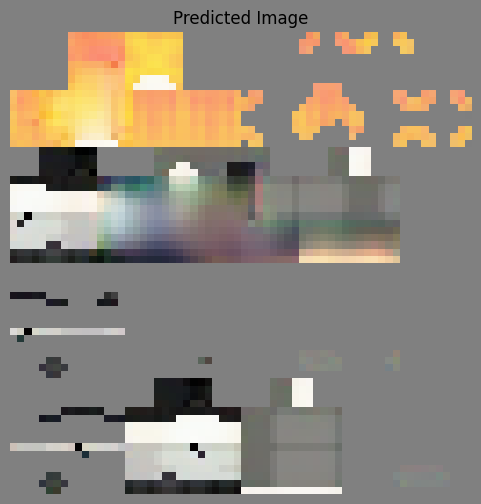

In [3]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

missing_image_path = 'Skins/0_missing.png'
mask_image_path = 'Skins/0_mask.png'

def load_image(path, channels=4):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]に正規化
    return image

missing = load_image(missing_image_path, channels=4)
mask = load_image(mask_image_path, channels=1)

missing = missing * mask

# 入力は欠損画像とマスクをチャネル方向に連結
input_image = tf.concat([missing, mask], axis=-1)

# バッチ次元を追加
input_image = tf.expand_dims(input_image, 0)

# 保存された学習済みモデルを読み込む
model = load_model('U_NET_checkpoint/UNET_01.h5', custom_objects={'total_loss': total_loss, "edge_loss": edge_loss, "l1_loss": l1_loss, "l2_loss": l2_loss, "mae_loss": mae_loss, "mse_loss": mse_loss, "ssim_loss": ssim_loss, "laplacian_loss": laplacian_loss})
# model = load_model("models/laplacian_loss.h5", custom_objects={"laplacian_loss": laplacian_loss})

predicted_image = model.predict(input_image)[0]

# 予測結果を表示

plt.figure(figsize=(6, 6)).set(facecolor='gray')
plt.imshow(predicted_image)
plt.title('Predicted Image')
plt.axis('off')
plt.show()

利用可能なフォント:
['C:\\Windows\\Fonts\\timesbi.ttf', 'C:\\Windows\\Fonts\\taile.ttf', 'C:\\Windows\\Fonts\\constanz.ttf', 'C:\\Windows\\Fonts\\framdit.ttf', 'C:\\Windows\\Fonts\\LeelUIsl.ttf', 'C:\\Windows\\Fonts\\meiryo.ttc', 'C:\\Windows\\Fonts\\UDDigiKyokashoN-B.ttc', 'C:\\Windows\\Fonts\\yuminl.ttf', 'C:\\Windows\\Fonts\\wingding.ttf', 'C:\\Windows\\Fonts\\calibriz.ttf', 'C:\\Windows\\Fonts\\timesi.ttf', 'C:\\Windows\\Fonts\\CascadiaCode.ttf', 'C:\\Windows\\Fonts\\courbi.ttf', 'C:\\Windows\\Fonts\\monbaiti.ttf', 'C:\\Windows\\Fonts\\arial.ttf', 'C:\\Windows\\Fonts\\seguihis.ttf', 'C:\\Windows\\Fonts\\Candarali.ttf', 'C:\\Windows\\Fonts\\timesbd.ttf', 'C:\\Windows\\Fonts\\segoeprb.ttf', 'C:\\Windows\\Fonts\\segoeuil.ttf', 'C:\\Windows\\Fonts\\l_10646.ttf', 'C:\\Windows\\Fonts\\cambriai.ttf', 'C:\\Windows\\Fonts\\corbeli.ttf', 'C:\\Windows\\Fonts\\ariali.ttf', 'C:\\Windows\\Fonts\\segoeuii.ttf', 'C:\\Windows\\Fonts\\seguiemj.ttf', 'C:\\Windows\\Fonts\\BIZ-UDGothicB.ttc', 'C:\\Windows\\Font

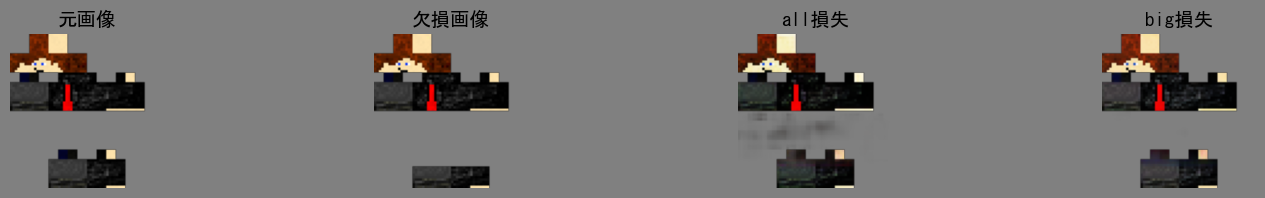

処理中: 00000b63941d43e1bbf67dd05edb2a75.png
1/1 [==============================] - 0s 19ms/step


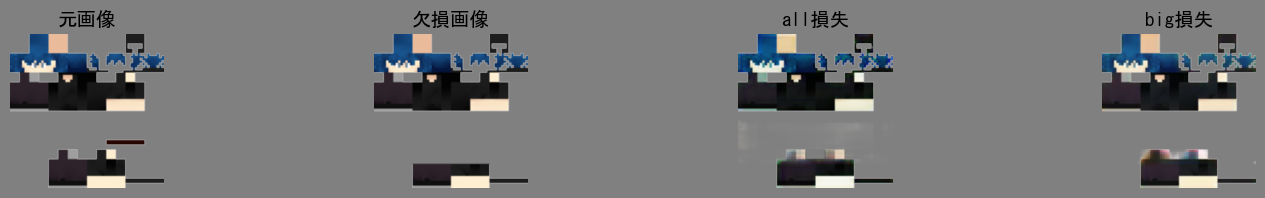

処理中: 0000101a3d5e45f7aac735ac604d4503.png
1/1 [==============================] - 0s 19ms/step


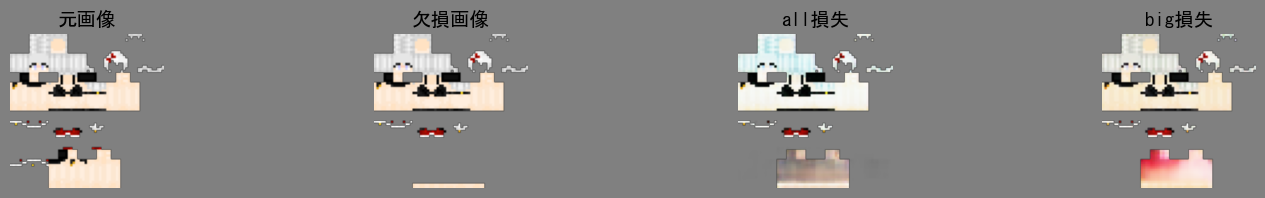

処理中: 00001a2825cf4de3bc3ca9fa956cd5e5.png
1/1 [==============================] - 0s 20ms/step


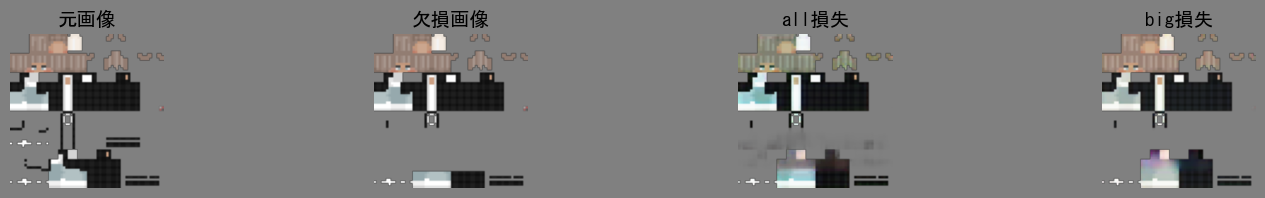

処理中: 000021bd7b774cae8a4081098ce8fb87.png
1/1 [==============================] - 0s 19ms/step


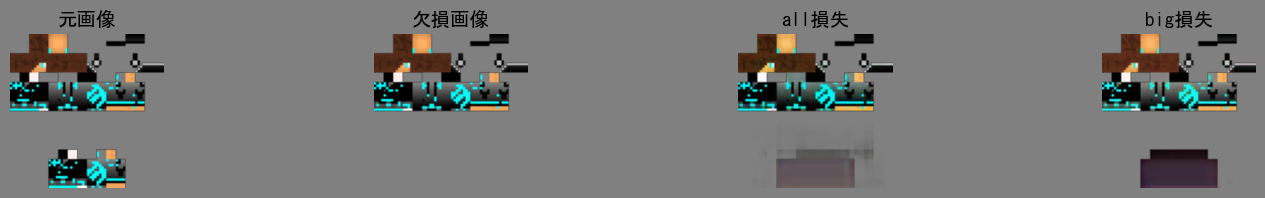

処理中: 000038872f4046cd959f21006a346980.png
1/1 [==============================] - 0s 19ms/step


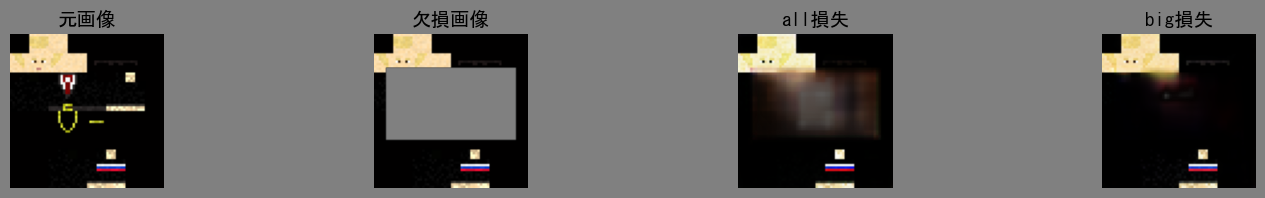

処理中: 00004361da1b4a528ada2caf9a104162.png
1/1 [==============================] - 0s 20ms/step


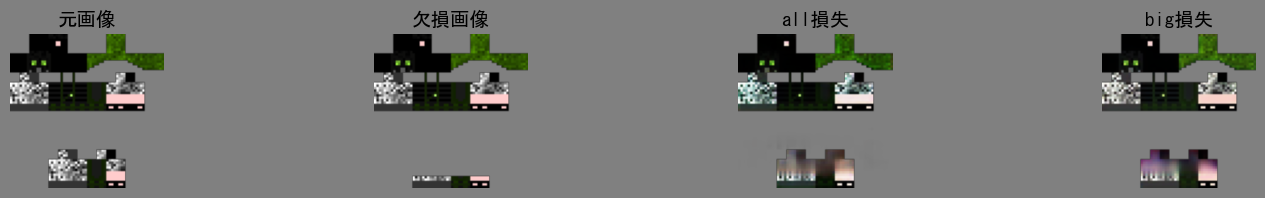

処理中: 0000566aa28347c4940654afc438008b.png
1/1 [==============================] - 0s 21ms/step


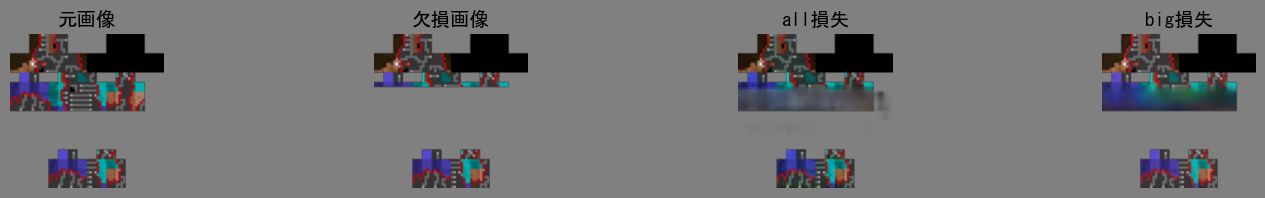

処理中: 00005e767e5a4f47a679a54b9e40abc9.png
1/1 [==============================] - 0s 21ms/step


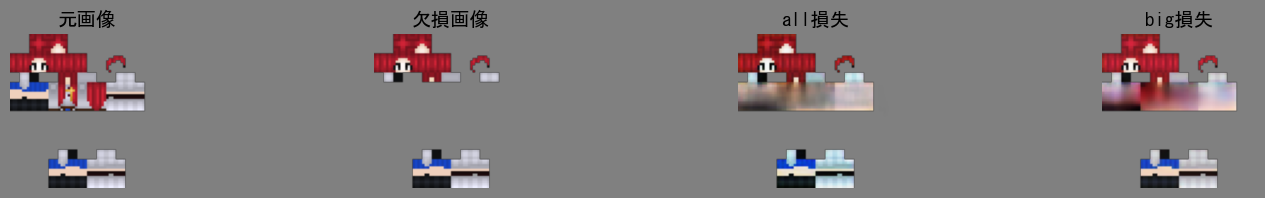

処理中: 00006a111c4d466198dba2bc5731f45c.png
1/1 [==============================] - 0s 20ms/step


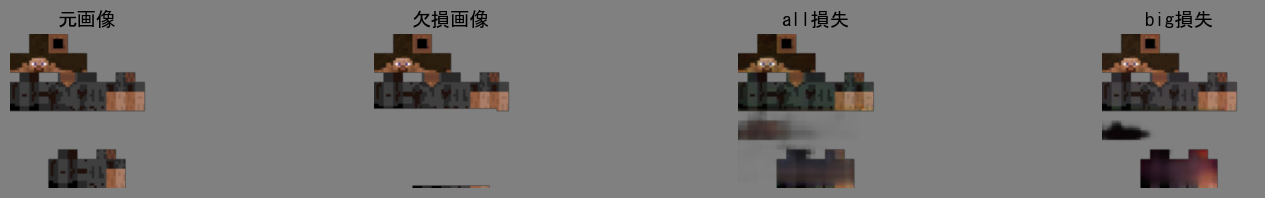

処理中: 00006cafa18c4fc79949685f3d8c67a3.png
1/1 [==============================] - 0s 20ms/step


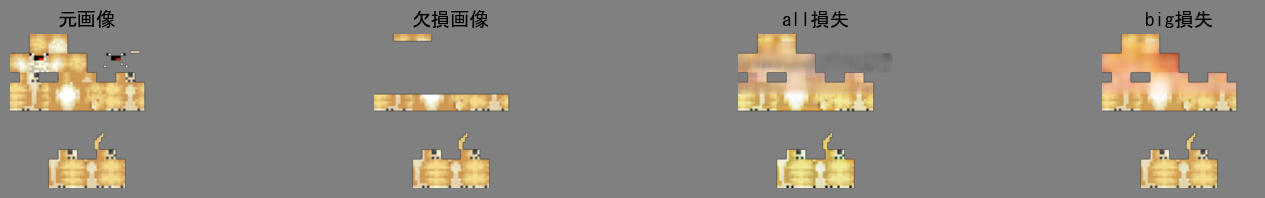

処理中: 0000861b7aee4af99bed0b5d4747143c.png
1/1 [==============================] - 0s 19ms/step


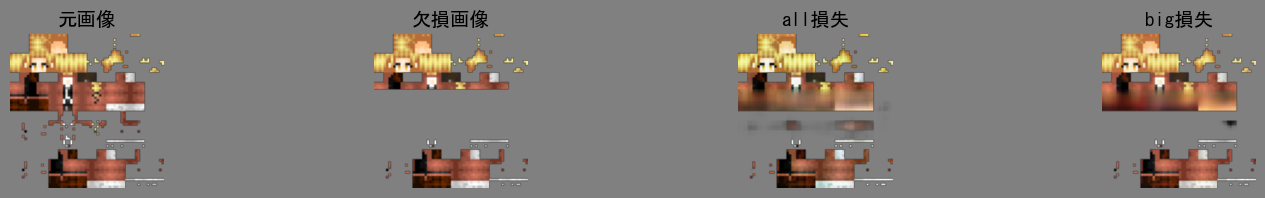

処理中: 0000c4eb1fa94a0e872359f2defb4e6e.png
1/1 [==============================] - 0s 20ms/step


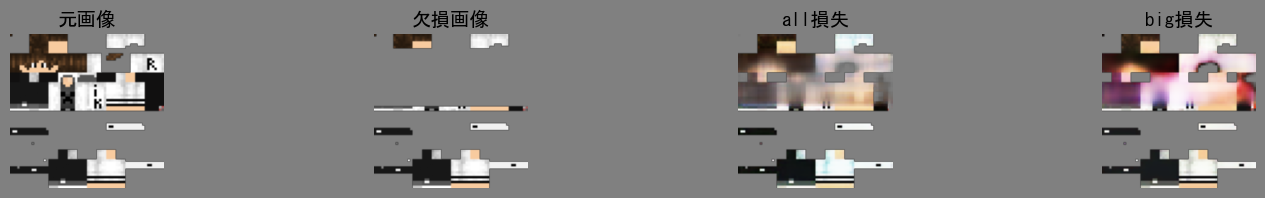

処理中: 0000cd004853453b919e01bbbcefcb09.png
1/1 [==============================] - 0s 18ms/step


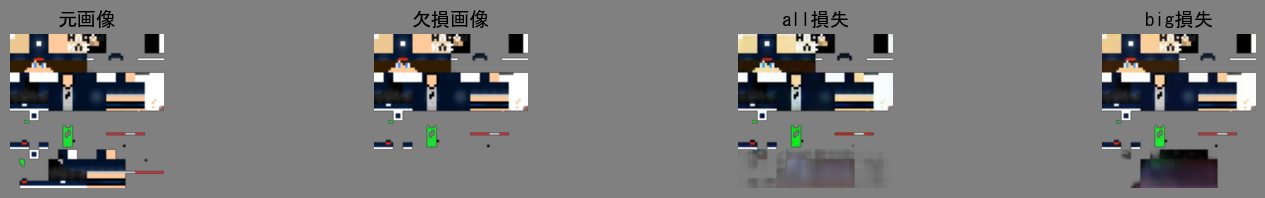

処理中: 0000d0c8b00b449280082601e43c1bd9.png
1/1 [==============================] - 0s 19ms/step


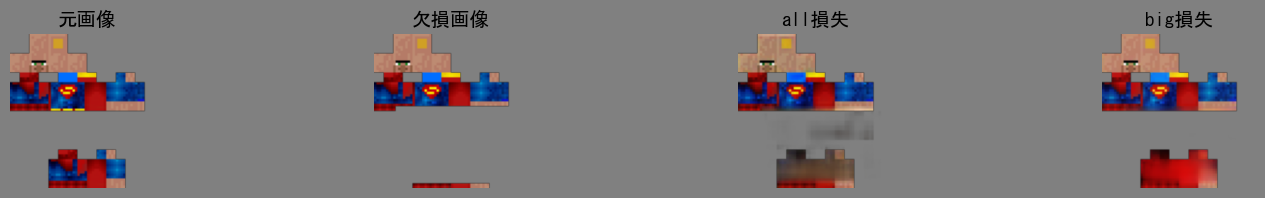

処理中: 0001048719354d2b98ed231400dd0f57.png
1/1 [==============================] - 0s 18ms/step


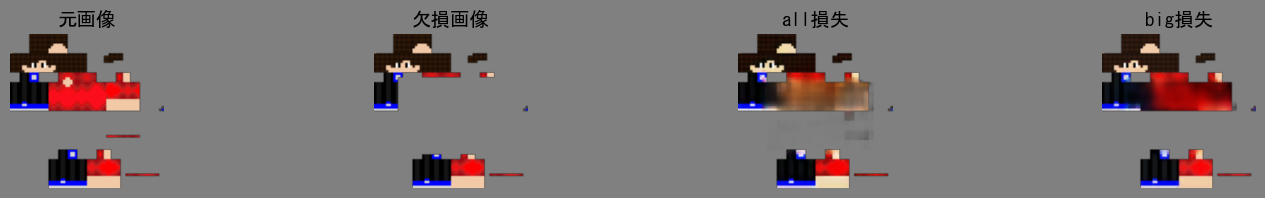

処理中: 00010ec0f1bf4f5495757cb2a897b559.png
1/1 [==============================] - 0s 30ms/step


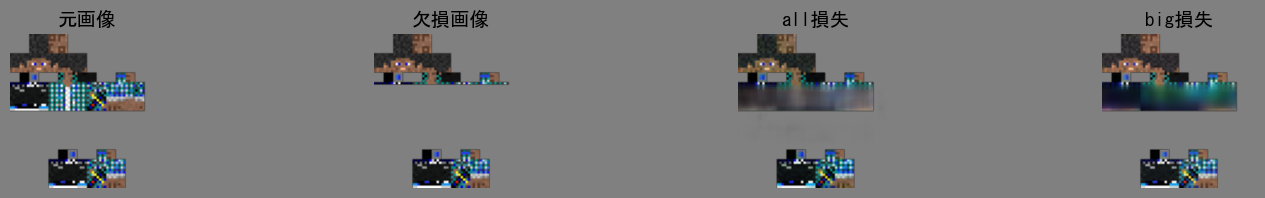

処理中: 000115f965b240de9c3fa58a630dea55.png
1/1 [==============================] - 0s 18ms/step


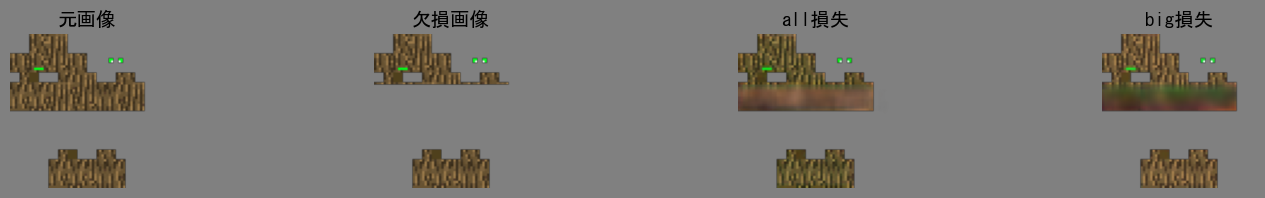

処理中: 00014339cb454055afbbb4d7a0c63a17.png
1/1 [==============================] - 0s 18ms/step


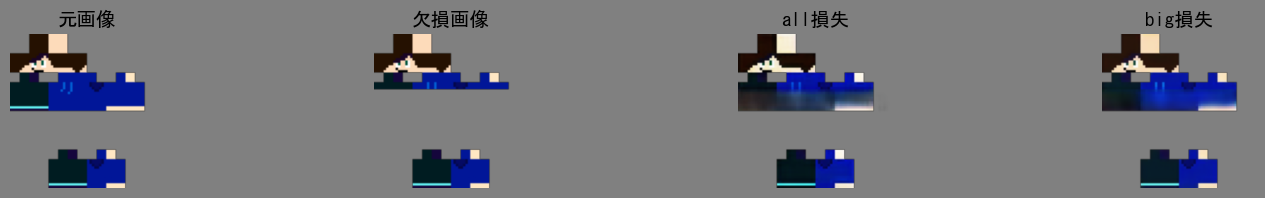

処理中: 000171e1be5b457db6b0981e83552763.png
1/1 [==============================] - 0s 20ms/step


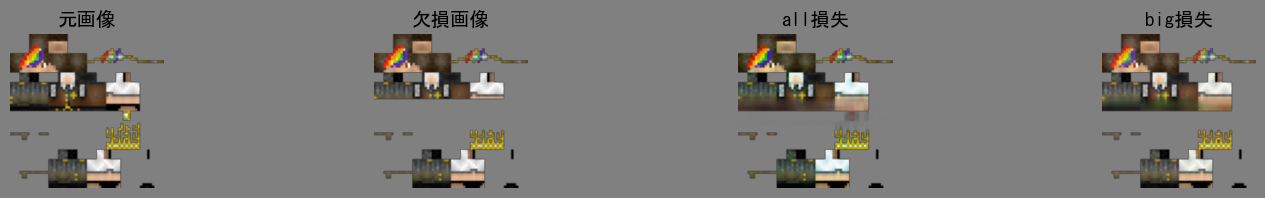

処理中: 00017f024d6f4d7f928ce6668aeff717.png
1/1 [==============================] - 0s 21ms/step


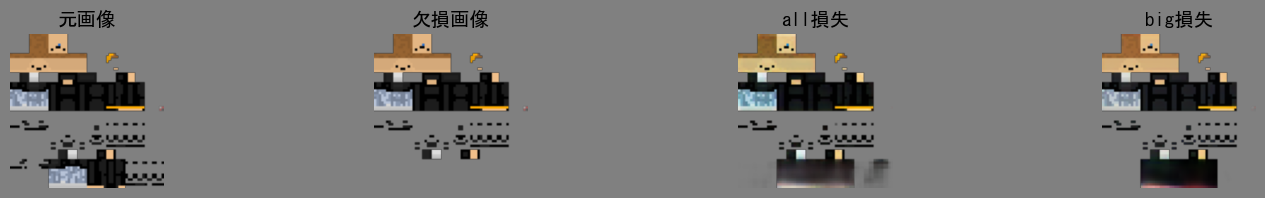

処理中: 00019ff2683a42dca4b7d631fdce2265.png
1/1 [==============================] - 0s 50ms/step


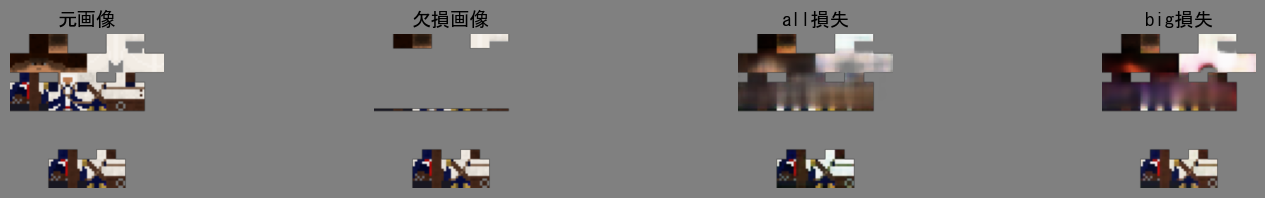

処理中: 0001b168823540eaa8a6c1abe0dfe297.png
1/1 [==============================] - 0s 20ms/step


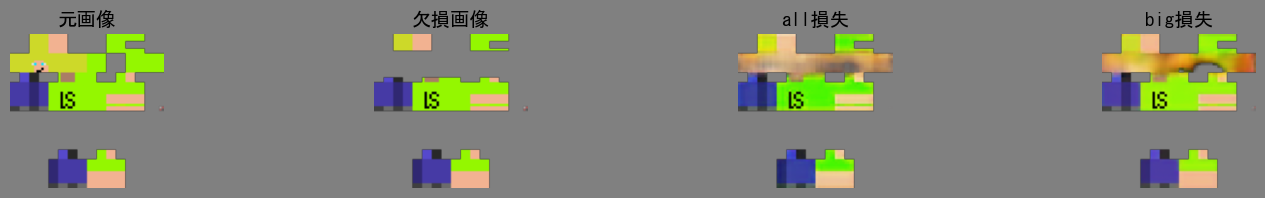

処理中: 0001b5a0e7d54741a93150fa3efa4efd.png
1/1 [==============================] - 0s 21ms/step


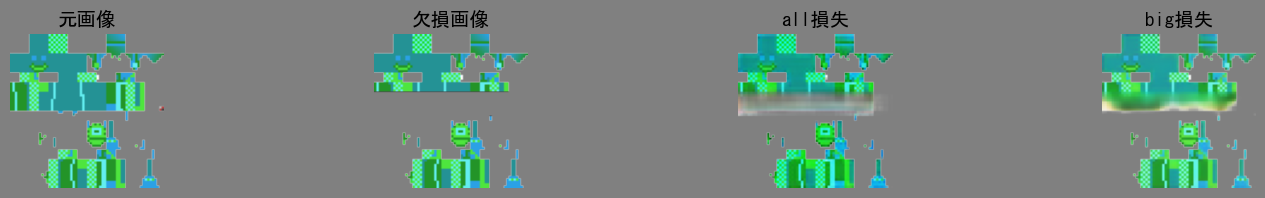

処理中: 0001ba5d9c244201858b494049799573.png
1/1 [==============================] - 0s 20ms/step


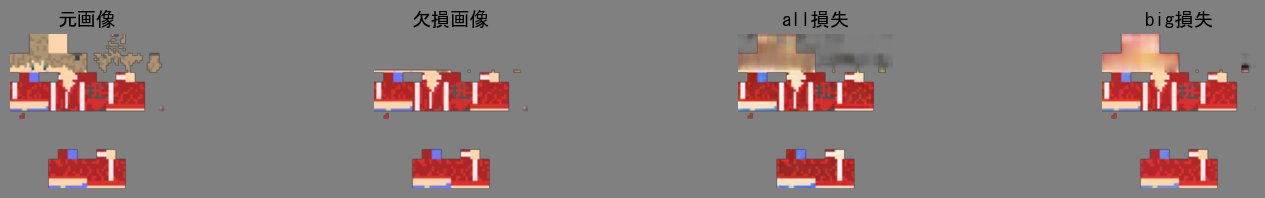

処理中: 0001d5de2b0f43ddbc21d226362935a8.png
1/1 [==============================] - 0s 40ms/step


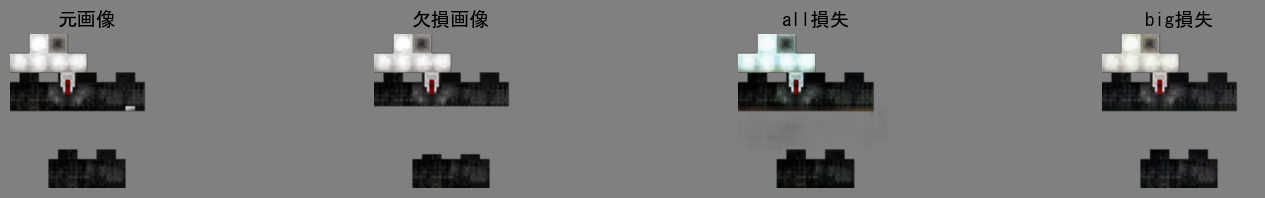

処理中: 0001f9c2445b4336868a0a2ab8940152.png
1/1 [==============================] - 0s 17ms/step


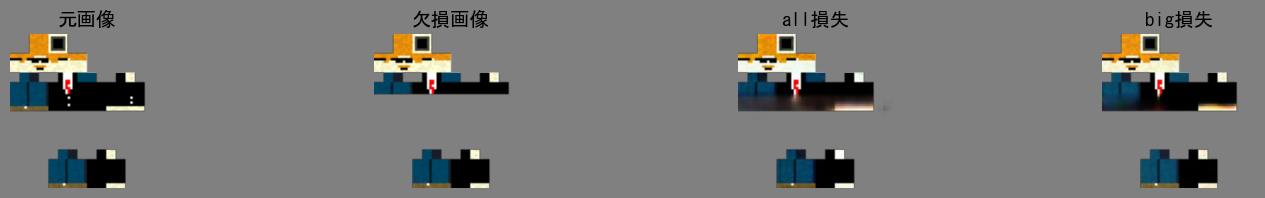

処理中: 00020c90f5a14bba884df29136b5c29e.png
1/1 [==============================] - 0s 20ms/step


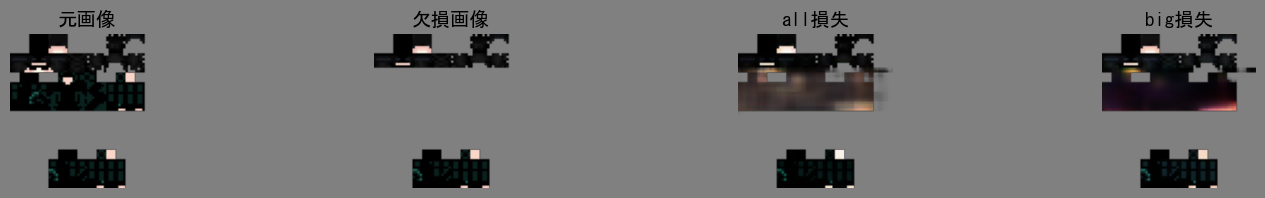

処理中: 000219123bb249eaa2b449c75073d42a.png
1/1 [==============================] - 0s 21ms/step


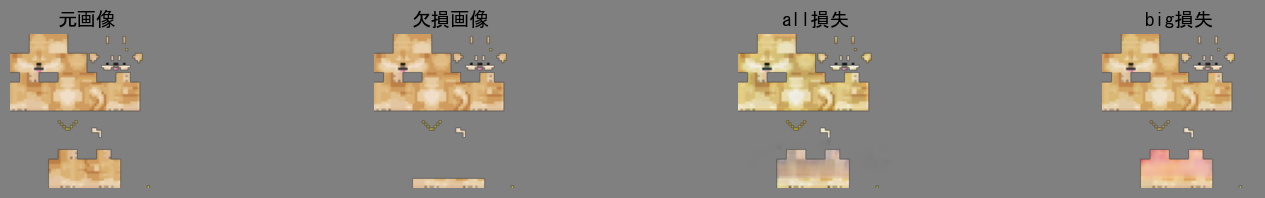

処理中: 0002197d3a434969b4c6cd216b64e0fc.png
1/1 [==============================] - 0s 36ms/step


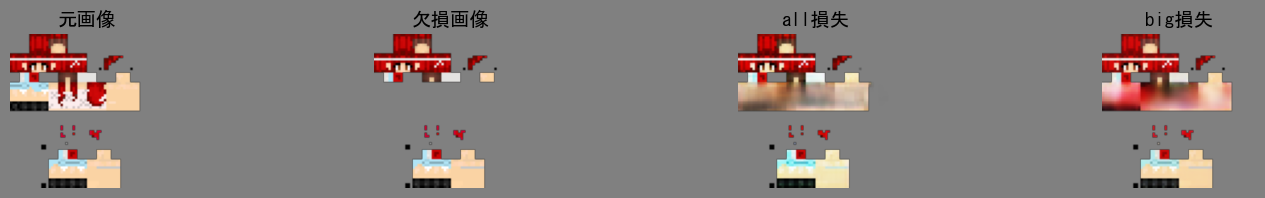

処理中: 000222280d5a47c3bdc0b570cf353ab6.png
1/1 [==============================] - 0s 21ms/step


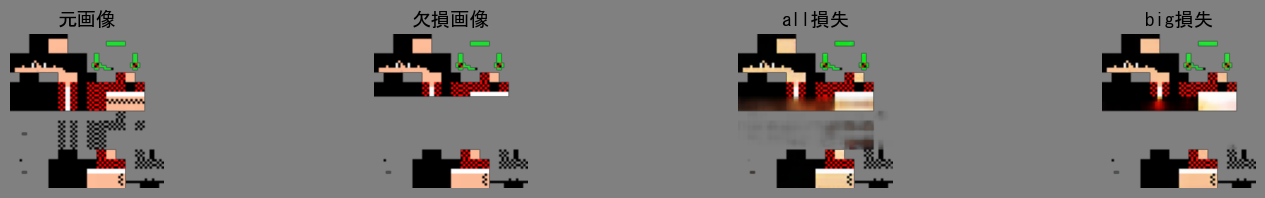

処理中: 00022d03b83947ee96c390c8feeb8a2d.png
1/1 [==============================] - 0s 35ms/step


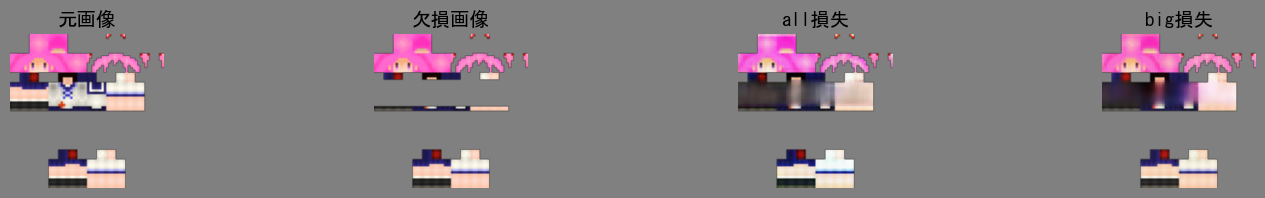

処理中: 00025b4612bd46c994f568f190d46c64.png
1/1 [==============================] - 0s 19ms/step


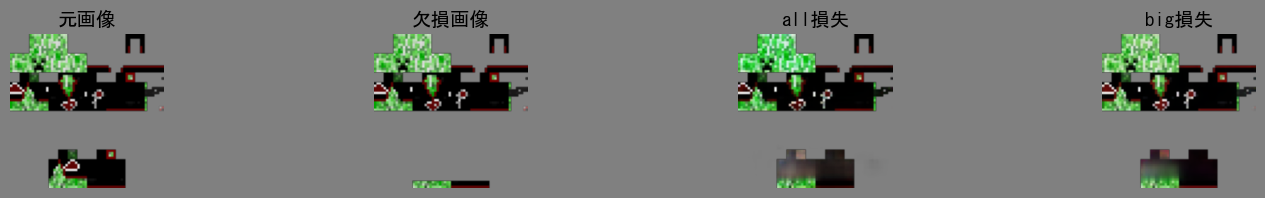

処理中: 00026a3cfd6549b9a11cf0ab90346e14.png
1/1 [==============================] - 0s 34ms/step


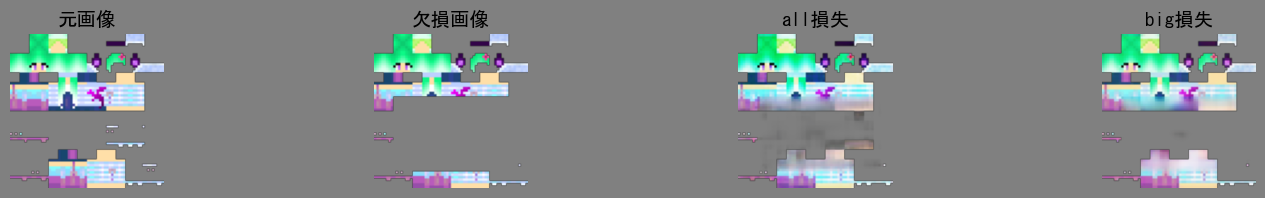

処理中: 00026f63409e49d9a083a9e5b1ab5527.png
1/1 [==============================] - 0s 19ms/step


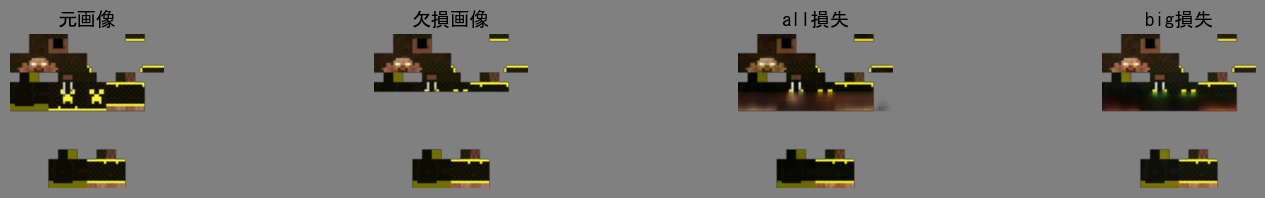

処理中: 0002787cf9884578838fd40887284f83.png
1/1 [==============================] - 0s 18ms/step


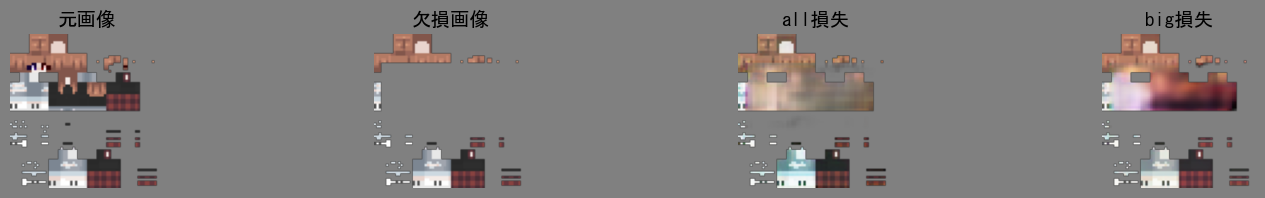

処理中: 00027b0b005c4f43a5a6b71c7e9f4497.png
1/1 [==============================] - 0s 38ms/step


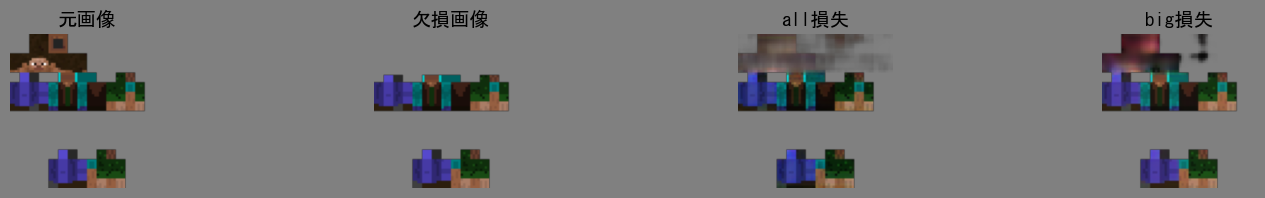

処理中: 000298f33b214675b03a2797a7af5011.png
1/1 [==============================] - 0s 20ms/step


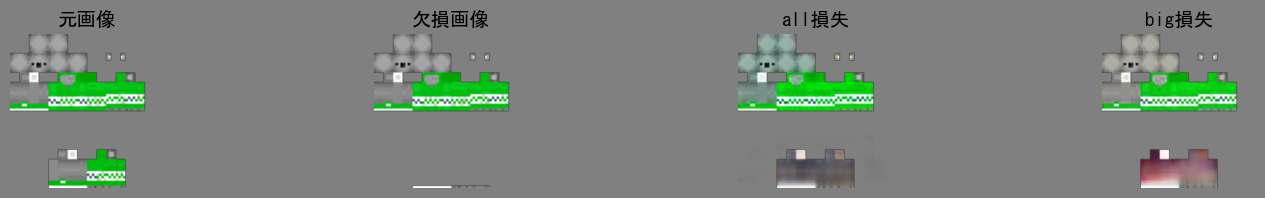

処理中: 0002af3b973c4778ad9f24d5274d3ae5.png
1/1 [==============================] - 0s 20ms/step


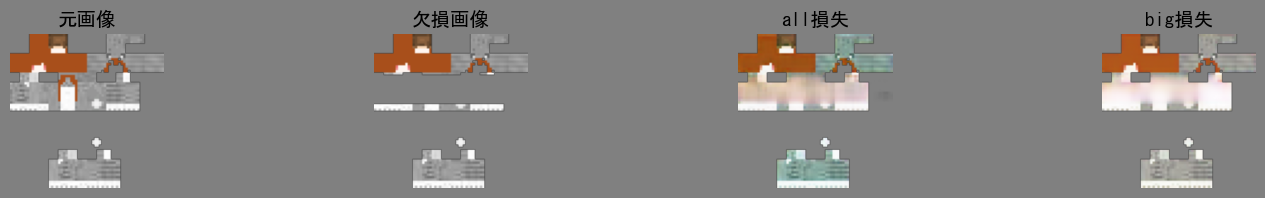

処理中: 0002b87bf1f541ad82d91d12eb06e56b.png
1/1 [==============================] - 0s 34ms/step


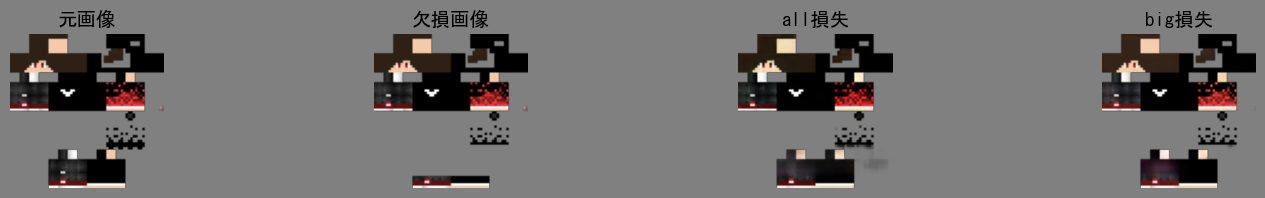

処理中: 0002c7e4008b40bf88d245a230ff29c3.png
1/1 [==============================] - 0s 19ms/step


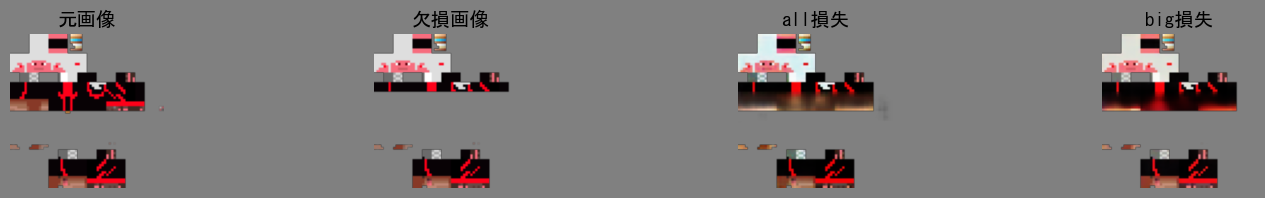

処理中: 0002cf1e2879431b88806d3d9d0385ad.png
1/1 [==============================] - 0s 20ms/step


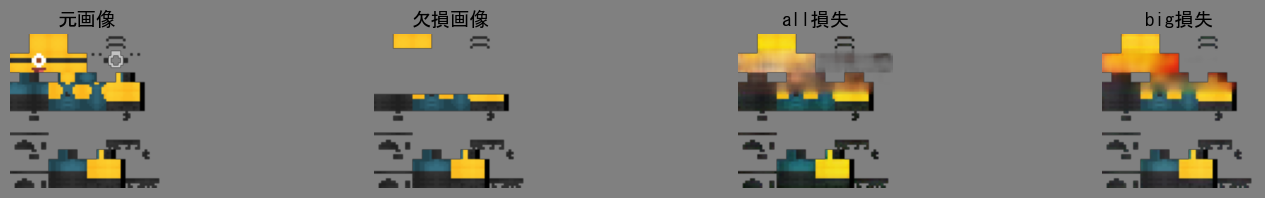

処理中: 0002e4e751b94eb3870f12162f1e453c.png
1/1 [==============================] - 0s 40ms/step


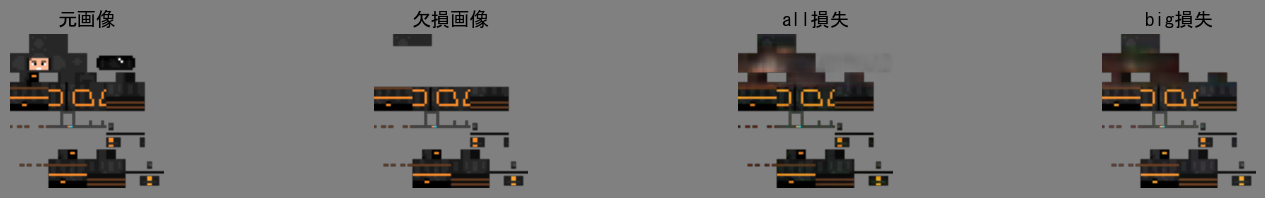

処理中: 000319ec0e204fdaafc0f98b4e5c96e4.png
1/1 [==============================] - 0s 18ms/step


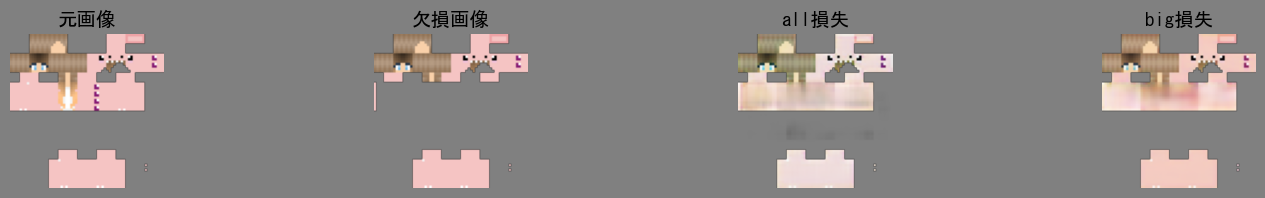

処理中: 00031ad3e85447cc87998837d9556cd1.png
1/1 [==============================] - 0s 21ms/step


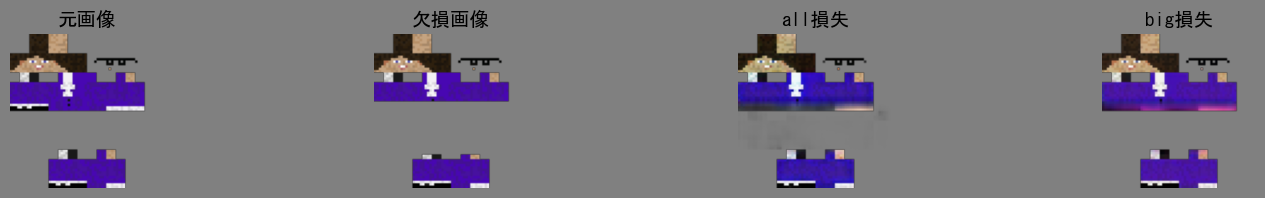

処理中: 00033121d6d1430daec4121fb63bb3e1.png
1/1 [==============================] - 0s 31ms/step


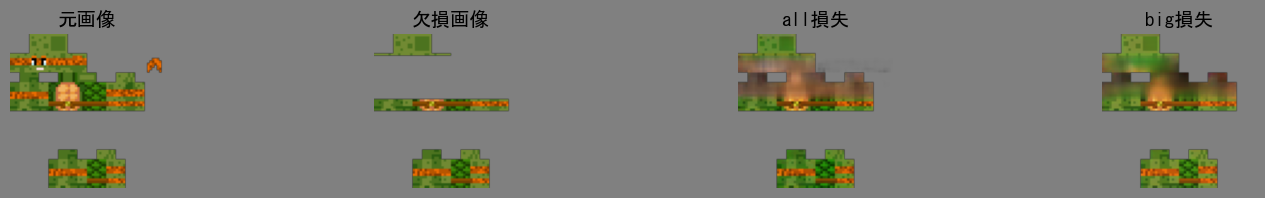

処理中: 00034f24949d44e4aef9bc4970dec75c.png
1/1 [==============================] - 0s 20ms/step


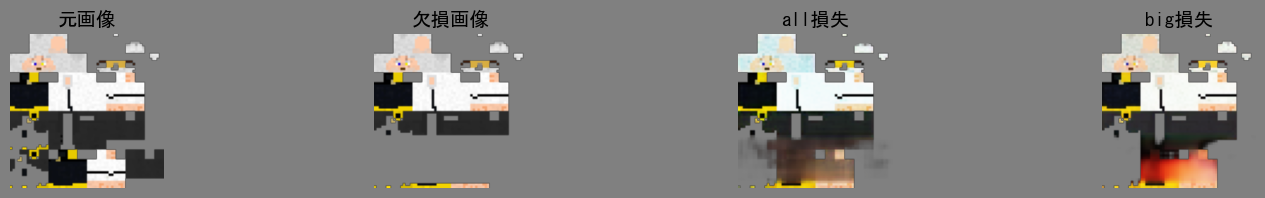

処理中: 00035cbf2fcb418eadf9e7b0c4b6c344.png
1/1 [==============================] - 0s 18ms/step


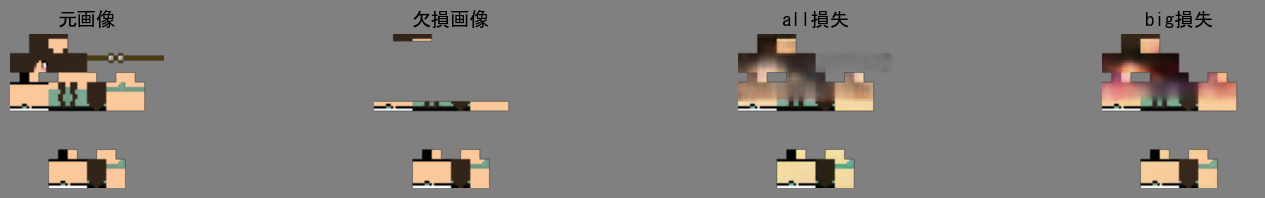

処理中: 0003698e86f345a295f3e3dfc221ca04.png
1/1 [==============================] - 0s 19ms/step


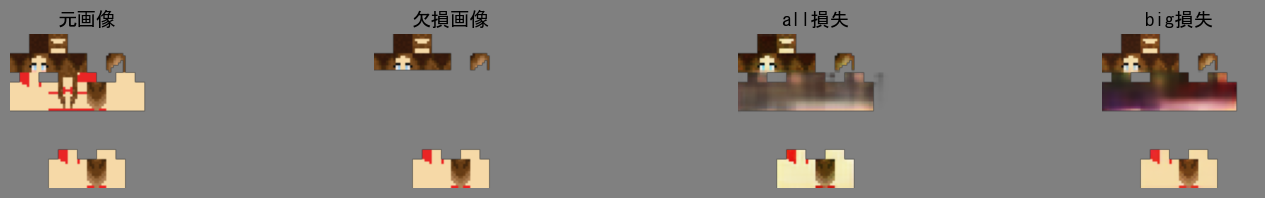

処理中: 0003866a04b74a8e9cf984416395aae4.png
1/1 [==============================] - 0s 20ms/step


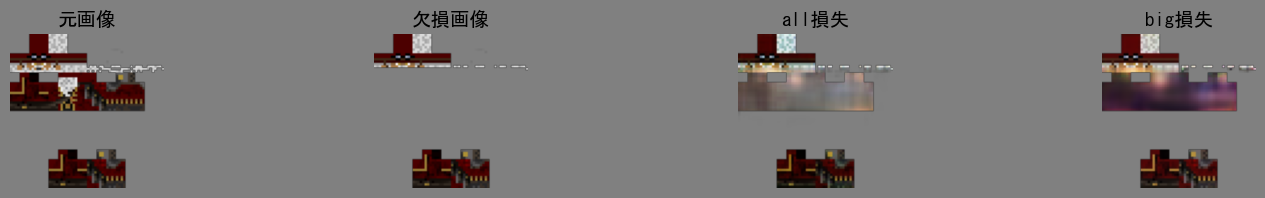

推論処理が完了しました。結果は以下のディレクトリに保存されています:
C:/Users/Owner/Desktop/archive/Results


In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import matplotlib as mpl

# 日本語フォントの設定
# Windows の場合
plt.rcParams['font.family'] = 'MS Gothic'  # Windows 標準の日本語フォント
# あるいは IPAフォントなどがインストール済みの場合
# plt.rcParams['font.family'] = 'IPAGothic'

# Mac の場合はコメントアウトを外す
# plt.rcParams['font.family'] = 'Hiragino Sans GB'

# Linux の場合はコメントアウトを外す
# plt.rcParams['font.family'] = 'Noto Sans CJK JP'

# ディレクトリパス設定
skins_dir = 'C:/Users/Owner/Desktop/archive/Skins'
missing_dir = 'C:/Users/Owner/Desktop/archive/Missing'
masks_dir = 'C:/Users/Owner/Desktop/archive/Masks'
output_dir = 'C:/Users/Owner/Desktop/archive/Results'

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 画像読み込み関数
def load_image(path, channels=4):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]に正規化
    return image

# 推論用サンプルの準備
def prepare_inference_sample(file_name):
    # ファイル名からパスを生成
    missing_file = tf.strings.join(["missing_", file_name])
    missing_path = tf.strings.join([missing_dir, missing_file], separator='/')
    mask_file = tf.strings.join(["mask_", file_name])
    mask_path = tf.strings.join([masks_dir, mask_file], separator='/')
    
    # 画像とマスクを読み込み
    missing = load_image(missing_path, channels=4)
    mask = load_image(mask_path, channels=1)
    
    # 入力は欠損画像とマスクをチャネル方向に連結
    input_image = tf.concat([missing, mask], axis=-1)
    
    # バッチ次元を追加
    input_image = tf.expand_dims(input_image, 0)
    
    return input_image, file_name

# 保存された学習済みモデルを読み込む
# model = load_model('U_NET/UNET_50000.h5')
# model = load_model('U_NET/UNET.h5', custom_objects={"total_loss": total_loss})
models_dir = {}
# models_dir["l1"] = load_model("models/l1_loss.h5", custom_objects={"l1_loss": l1_loss})
# models_dir["l2"] = load_model("models/l2_loss.h5", custom_objects={"l2_loss": l2_loss})
# models_dir["edge"] = load_model("models/edge_loss.h5", custom_objects={"edge_loss": edge_loss})
# models_dir["mae"] = load_model("models/mae_loss.h5", custom_objects={"mae_loss": mae_loss})
# models_dir["mae_2"] = load_model("models/mae_2_loss.h5")
# models_dir["mse"] = load_model("models/mse_loss.h5", custom_objects={"mse_loss": mse_loss})
# models_dir["mse_2"] = load_model("models/mse_2_loss.h5")
# models_dir["ssim"] = load_model("models/ssim_loss.h5", custom_objects={"ssim_loss": ssim_loss})
# models_dir["total"] = load_model("models/total_loss.h5", custom_objects={"total_loss": total_loss})
# models_dir["laplacian"] = load_model("models/laplacian_loss.h5", custom_objects={"laplacian_loss": laplacian_loss})
models_dir["all"] = model = load_model('models/all_loss.h5', custom_objects={'total_loss': total_loss, "edge_loss": edge_loss, "l1_loss": l1_loss, "l2_loss": l2_loss, "mae_loss": mae_loss, "mse_loss": mse_loss, "ssim_loss": ssim_loss, "laplacian_loss": laplacian_loss})
models_dir["big"] = model = load_model("U_NET_checkpoint/UNET_01.h5", custom_objects={'total_loss': total_loss, "edge_loss": edge_loss, "l1_loss": l1_loss, "l2_loss": l2_loss, "mae_loss": mae_loss, "mse_loss": mse_loss, "ssim_loss": ssim_loss, "laplacian_loss": laplacian_loss})

# テスト用画像ファイル名のリストを取得
test_files = os.listdir(skins_dir)
test_files = [f for f in test_files if f.endswith('.png')]

# テスト画像数の制限（必要に応じて）
test_limit = 50
test_files = test_files[:test_limit]

# 単一画像の推論を行う関数（特定の画像に対して処理したい場合）
def infer_single_image(filename):
    # 推論用サンプルを準備
    input_image, _ = prepare_inference_sample(filename)
    
    # # 推論実行
    # predicted_skin = model.predict(input_image)[0]

    predicted_skins = []
    for model in models_dir.values():
        predicted_skins.append(model.predict(input_image)[0])
    
    # 元の画像も読み込む（比較用）
    missing_path = os.path.join(missing_dir, f"missing_{filename}")
    missing_image = load_image(missing_path).numpy()
    
    original_path = os.path.join(skins_dir, filename)
    original_image = load_image(original_path).numpy()
    
    # 結果の可視化と表示
    # plt.figure(figsize=(15, 5))
    fig, axes = plt.subplots(1, 2+len(models_dir), figsize=(18, 2))
    fig.patch.set_facecolor('gray')
    
    # 元の画像
    axes[0].imshow(original_image)
    axes[0].set_title('元画像', fontsize=14)
    axes[0].axis('off')

    # 欠損画像
    axes[1].imshow(missing_image)
    axes[1].set_title('欠損画像', fontsize=14)
    axes[1].axis('off')

    for i, (key, predicted_skin) in enumerate(zip(models_dir.keys(), predicted_skins)):
        axes[i+2].imshow(predicted_skin)
        axes[i+2].set_title(f'{key}損失', fontsize=14)
        axes[i+2].axis('off')
    
    # # タイトルがきちんと表示されるよう余白調整
    # plt.tight_layout()

    plt.show()
    
    return predicted_skins

# メイン実行部分
if __name__ == "__main__":
    # フォント設定の確認
    print("利用可能なフォント:")
    print(mpl.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))

    # 全てのテスト画像で推論を実行
    print("個別推論処理を開始します...")
    for file_name in test_files:
        print(f"処理中: {file_name}")
        infer_single_image(file_name)
    
    # または、より効率的なバッチ処理で推論
    # print("バッチ推論処理を開始します...")
    # batch_inference(batch_size=16)
    
    print("推論処理が完了しました。結果は以下のディレクトリに保存されています:")
    print(output_dir)